# Gradient boosted model

The model combines predictions from multiple models to improve to overall model. The difference is how they are combined.

- Scikit-survival: https://scikit-survival.readthedocs.io/en/stable/user_guide/boosting.html

### Base learners 
- sksurv.ensemble.GradientBoostingSurvivalAnalysis implements gradient boosting with regression tree base learner, and sksurv.ensemble. I's very versatile and can accoount for complicated non-linear relationship between features and time to survival
- ComponentwiseGradientBoostingSurvivalAnalysis uses component-wise least squares as base learner. The final model will be a linear model but only a small subset of features be selected

### Loss function
__Cox’s Partial Likelihood__
The loss function can be specified via the loss argument loss; the default loss function is the partial likelihood loss of Cox’s proportional hazards model (coxph). Therefore, the objective is to maximize the log partial likelihood function, but replacing the traditional linear model with the additive model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sksurv.datasets import load_gbsg2
from sklearn.preprocessing import OrdinalEncoder
from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sksurv.datasets import load_breast_cancer
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

We are going to use data from the German Breast Cancer Study Group (GBSG-2) on the treatment of node-positive breast cancer patients. 

It contains data on 686 women and 8 prognostic factors: 
1. age
2. estrogen receptor (estrec)
3. whether or not a hormonal therapy was administered (horTh)
4. menopausal status (menostat)
5. number of positive lymph nodes (pnodes)
6. progesterone receptor (progrec)
7. tumor size (tsize)
8. tumor grade (tgrade).

The dataset is one of the sksurv.datasets 

In [2]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

# Next, the data is split into 75% for training and 25% for testing, so we can determine how well our model generalizes.


random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

__Use gradient Boosting on Cox's partial likelihood with regression trees base learners, which we restrict to using only a singple slipt__

In [3]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3)) # concordance indext

0.665


__how the test performance changes with the ensemble size (n_estimators).__

In [4]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

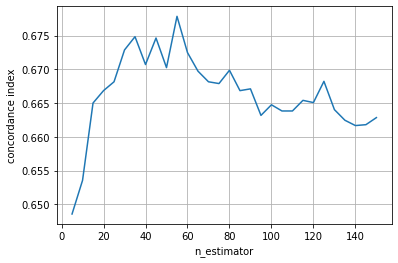

In [5]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

We can see that the performance quickly improves, but also that the performance starts to decrease if the ensemble becomes too big.

__Let’s repeat the analysis using component-wise least squares base learners.__



In [6]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    learning_rate=1.0, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

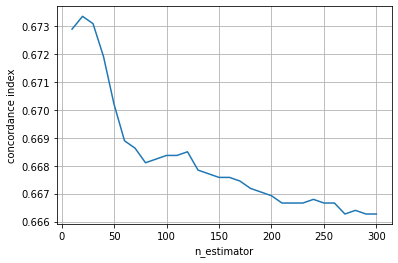

In [7]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

The performance increase is much slower here and its maximum performance seems to be below that of the ensemble of tree-based learners. This is not surprising, because with component-wise least squares base learners the overall ensemble is a linear model, whereas with tree-based learners it will be a non-linear model.


__The coefficients of the model can be retrieved as follows:__
Despite using hundreds of iterations, the resulting model is very parsimonious and easy to interpret.



In [8]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + Xt.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 8


tgrade           0.244903
horTh=yes       -0.222642
menostat=Post    0.056024
pnodes           0.042934
tsize            0.009107
progrec         -0.002710
age              0.000416
estrec          -0.000127
dtype: float64

In [9]:
survival = est_cph_ls.predict_survival_function(X_test)

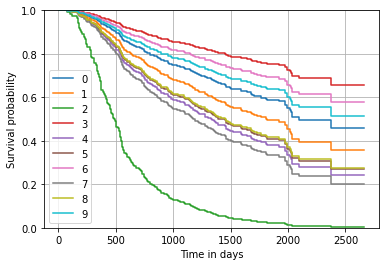

In [10]:
# Document link: https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.ensemble.GradientBoostingSurvivalAnalysis.html#sksurv.ensemble.GradientBoostingSurvivalAnalysis.predict_survival_function

for i, fn in enumerate(survival[:10]):
    plt.step(fn.x, fn(fn.x), where="post",label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

# Accelerated Failure Time Model
The Accelerated Failure Time (AFT) model is an alternative to Cox’s proportional hazards model. The latter assumes that features only influence the hazard function via a constant multiplicative factor. In contrast, features in an AFT model can accelerate or decelerate the time to an event by a constant factor. 

Such a model can be fit with sksurv.ensemble.GradientBoostingSurvivalAnalysis or sksurv.ensemble.ComponentwiseGradientBoostingSurvivalAnalysis by specifying the loss="ipcwls" argument.

In [11]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss="ipcwls", n_estimators=300, learning_rate=1.0, random_state=0
).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

0.691


In [24]:
X_test_sorted = X_test.sort_values(by=["pnodes", "age"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0


In [25]:

X_test_sel['predict'] = est_cph_ls.predict(X_test_sel)
X_test_sel

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade,predict
119,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0,0.794756
574,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0,0.906478
421,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0,0.422908
24,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0,2.313107
8,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0,1.969901
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0,2.064329


## Regularization
The most important parameter in gradient boosting is the number of base learner to use (n_estimators argument). A higher number will lead to a more complex model. However, this can easily lead to overfitting on the training data. The easiest way would be to just use less base estimators, but there are three alternatives to combat overfitting:

- Use a learning_rate less than 1 to restrict the influence of individual base learners, similar to the Ridge penalty.

- Use a non-zero dropout_rate, which forces base learners to also account for some of the previously fitted base learners to be missing.

- Use subsample less than 1 such that each iteration only a portion of the training data is used. This is also known as stochastic gradient boosting.


In [ ]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, max_depth=1, random_state=0
    ),
    "learning rate": GradientBoostingSurvivalAnalysis(
        learning_rate=0.1, max_depth=1, random_state=0
    ),
    "dropout": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0
    ),
    "subsample": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0
    ),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

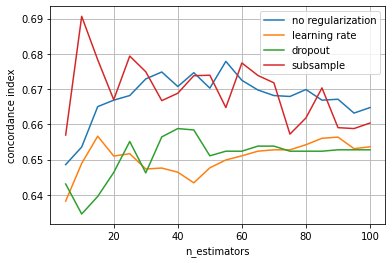

In [ ]:
ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

The plot reveals that using dropout or a learning rate are most effective in avoiding overfitting. Moreover, the learning rate and ensemble size are strongly connected, choosing smaller a learning rate suggests increasing n_estimators. Therefore, it is recommended to use a relatively small learning rate and select the number of estimators via early stopping. Note that we can also apply multiple types of regularization, such as regularization by learning rate and subsampling. Since not all training data is used, this allows using the left-out data to evaluate whether we should continue adding more base learners or stop training.

In [ ]:
class EarlyStoppingMonitor:

    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.5,
    max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

Fitted base learners: 192
Performance on test set 0.685


The monitor looks at the average improvement of the last 25 iterations, and if it was negative for the last 50 iterations, it will abort training. In this case, this occurred after 119 iterations. We can plot the improvement per base learner and the moving average.



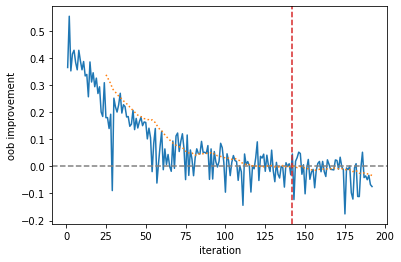

In [ ]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_,
    index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")

# Permutation Feature importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(est_early_stopping, n_iter=15, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=Xt.columns.tolist())

Using TensorFlow backend.


Weight,Feature
0.0836 ± 0.0195,pnodes
0.0319 ± 0.0548,progrec
0.0233 ± 0.0123,age
0.0057 ± 0.0042,horTh=yes
0.0054 ± 0.0126,tsize
0 ± 0.0000,menostat=Post
-0.0006 ± 0.0016,tgrade
-0.0015 ± 0.0057,estrec
